# Set up environments

In [1]:
!pip install -q beautifulsoup4==4.12.2 PyMuPDFb==1.24.10 PyMuPDF==1.24.13 tqdm==4.66.5 duckdb==0.10.0 tabulate==0.9.0 plotly==5.20.0 python-dotenv openai==1.42.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.9 MB/s eta 0:00:00


In [2]:
import os

if not ".git" in os.listdir():
    !git clone https://github.com/batprem/pyo3-experiment
    os.chdir("pyo3-experiment")

Cloning into 'pyo3-experiment'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 29 (delta 5), reused 29 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 15.88 KiB | 2.27 MiB/s, done.
Resolving deltas: 100% (5/5), done.


# Download 56-1 file

In [3]:
import requests
from bs4 import BeautifulSoup
import os
import zipfile
from tqdm import tqdm


ROOT = "downloaded-56-1"
SYMBOL = "PTT"  # Change this symbol
# SYMBOL = "KBANK"  # Change this symbol
FILE_PATH = f"{ROOT}/{SYMBOL}"
PATH_TO_TARGET = f"{FILE_PATH}/{SYMBOL}.zip"
session = requests.Session()



os.makedirs(FILE_PATH, exist_ok=True)
print("Searching the balance sheet file")

response = session.get(
    f"https://market.sec.or.th/public/idisc/th/Viewmore/fs-r561?searchSymbol={SYMBOL}",
)
soup = BeautifulSoup(response.text)
url = soup.find_all("tr")[1].find_all("td")[-1].find("a")["href"]

print(f"Found at {url}")
# Sizes in bytes.
total_size = int(response.headers.get("content-length", 0))
block_size = 1024
response = session.get(url, stream=True)

print("Downloading...")
with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(PATH_TO_TARGET, "wb") as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)


# with open(PATH_TO_TARGET, "wb") as f:
#     f.write(requests.get(url).content)

with zipfile.ZipFile(PATH_TO_TARGET, 'r') as zip_ref:
    zip_ref.extractall(FILE_PATH)
print("Done")

Searching the balance sheet file
Found at https://market.sec.or.th/public/idisc/Download?FILEID=dat/f56/0646ONE140320241323370901T.zip
Downloading...


44.0MB [01:21, 543kB/s]


Done


# Extract table of contents

In [4]:
import fitz
import pandas as pd

def to_html(filepath: str):
    doc = fitz.open(filepath)
    for i, page in enumerate(doc):
        text = page.get_text("html")
        with open(f"pymupdf-page-{i}.html", "w") as fp:
            fp.write(text)
    doc.close()

doc = fitz.open(f'{FILE_PATH}/STRUCTURE{SYMBOL}T.PDF')
toc = pd.DataFrame(doc.get_toc())
toc.columns = ["hierachy", "topic", "page"]
toc = toc[toc["topic"] != "Bookmark"].reset_index(drop=True)
toc

,hierachy,topic,page
0,1,Cover,1
1,1,TableContent,2
2,1,StructureAndOperation,4
3,1,RiskManagement,9
4,1,ESG,13
5,1,CorporateGovernancePolicy,18
6,1,CorporateGovernanceStructure,20
7,1,ResultOfCorporateGovernance,32


In [5]:
bussiness_type = doc[3].get_text().split("ประเภทธุรกิจ\n:")[1].strip().split("\nเลขทะเบียนบริษัท")[0]
print(bussiness_type)

ประกอบด้วยกิจการที่ ปตท. ดำเนินการเอง ได้แก่ ธุรกิจก๊าซธรรมชาติ ธุรกิจ
ระบบท่อส่งก๊าซธรรมชาติ ธุรกิจการค้าระหว่างประเทศ
ธุรกิจใหม่และโครงสร้างพื้นฐาน และธุรกิจที่ลงทุนผ่านบริษัทย่อยและ/หรือ
กิจการที่ควบคุมร่วมกันและบริษัทร่วม (กลุ่มบริษัท) ได้แก่ ธุรกิจสำรวจและผลิต
ปิโตรเลียม ธุรกิจก๊าซธรรมชาติเหลว ธุรกิจปิโตรเคมีและการกลั่น ธุรกิจน้ำมัน
และค้าปลีก ธุรกิจไฟฟ้าและสาธารณูปการ ธุรกิจให้บริการ


In [6]:
first_page_index = toc.index[toc["topic"] == "StructureAndOperation"][0]
end_page_index = first_page_index + 1
first_page, end_page = toc.loc[[first_page_index, end_page_index]]["page"].to_list()

In [8]:
from IPython.display import display
import duckdb

structure_type = "Not defined"

def get_sql_create_a_table_from_dataframe(df: pd.DataFrame, name: str) -> str:
    duckdb.sql(f"CREATE OR REPLACE TABLE '{name}' AS SELECT * FROM df")

    # insert into the table "my_table" from the DataFrame "my_df"
    duckdb.sql(f"INSERT INTO '{name}' SELECT * FROM df")


for page in range(first_page, end_page):
    for table in doc[page].find_tables():
        df = table.to_pandas()
        if "Col1" in df.columns:
            columns_list = df.columns.to_list()
            columns_list[1:] = df.iloc[0].to_list()[1:]
            structure_type = columns_list[0]
            columns_list[0] = "detail"
            df.columns = columns_list
            df = df.iloc[1:]

        if "Col0" in df.columns:
            df.columns = columns_list
        get_sql_create_a_table_from_dataframe(df, structure_type)
        # display(df)

In [9]:
tables = duckdb.sql("SHOW TABLES")

In [10]:
table = "โครงสร้างรายได้จากในประเทศและจากต่างประเทศ"
income_domestic_foriegn = duckdb.sql(f"SELECT * FROM '{table}'").to_df().drop_duplicates().to_markdown(index=False)
print(income_domestic_foriegn)

| detail                     |   2564 |   2565 |   2566 |
|:---------------------------|-------:|-------:|-------:|
| รายได้จากการดำเนินงานรวม (%) | 100    | 100    | 100    |
| รายได้จากในประเทศ (%)       |  58.86 |  57.42 |  55.46 |
| รายได้จากต่างประเทศ (%)      |  41.14 |  42.58 |  44.54 |


In [11]:
revenue_by_business_group = duckdb.sql("SELECT * FROM 'โครงสร้างรายได้ของสายผลิตภัณฑ์หรือกลุ่มธุรกิจ'").to_df().drop_duplicates().to_markdown(index=False)
print(revenue_by_business_group)

| detail                      |   2564 |   2565 |   2566 |
|:----------------------------|-------:|-------:|-------:|
| รายได้จากการดำเนินงานรวม (%)  | 100    | 100    | 100    |
| สำรวจและผลิตปิโตรเลียม (%)     |   2.81 |   2.48 |   2.42 |
| ก๊าซธรรมชาติ (%)              |  14.06 |  15.13 |  15.01 |
| น้ำมัน (%)                    |  22.31 |  23.06 |  23.43 |
| ปิโตรเคมีและการกลั่น (%)        |  30.31 |  26.48 |  24.99 |
| การค้าระหว่างประเทศ (%)       |  27.2  |  28.44 |  31.14 |
| ธุรกิจใหม่และโครงสร้างพื้นฐาน (%) |   2.58 |   3.47 |   2.94 |
| อื่นๆ (%)                     |   0.73 |   0.94 |   0.07 |


In [12]:
other_income_stated_in_financial_statements = duckdb.sql("SELECT * FROM 'รายได้อื่น ตามที่ระบุในงบการเงิน'").to_df().drop_duplicates().to_markdown(index=False)
print(other_income_stated_in_financial_statements)

| รายการ (หน่วย : พันบาท)                       | 2564   | 2565   | 2566   |
|:--------------------------------------------|:-------|:-------|:-------|
| ค่าใช้จ่ายการทำวิจัยและพัฒนา (R&D) ในระยะเวลา 3 ปี | N/A    | N/A    | N/A    |
| ที่ผ่านมา                                      |        |        |        |


In [13]:
from string import Template


template = Template("""
Stock name: ${SYMBOL}
Business: ${bussiness_type}
Structure:

โครงสร้างรายได้จากในประเทศและจากต่างประเทศ:
${income_domestic_foriegn}

โครงสร้างรายได้ของสายผลิตภัณฑ์หรือกลุ่มธุรกิจ
${revenue_by_business_group}

รายได้อื่นตามที่ระบุในงบการเงิน
${other_income_stated_in_financial_statements}

Your task:
${task}
""")

print(
    template.safe_substitute(
        SYMBOL=SYMBOL,
        bussiness_type=bussiness_type,
        income_domestic_foriegn=income_domestic_foriegn,
        revenue_by_business_group=revenue_by_business_group,
        other_income_stated_in_financial_statements=other_income_stated_in_financial_statements,
    )
)


Stock name: PTT
Business: ประกอบด้วยกิจการที่ ปตท. ดำเนินการเอง ได้แก่ ธุรกิจก๊าซธรรมชาติ ธุรกิจ
ระบบท่อส่งก๊าซธรรมชาติ ธุรกิจการค้าระหว่างประเทศ
ธุรกิจใหม่และโครงสร้างพื้นฐาน และธุรกิจที่ลงทุนผ่านบริษัทย่อยและ/หรือ
กิจการที่ควบคุมร่วมกันและบริษัทร่วม (กลุ่มบริษัท) ได้แก่ ธุรกิจสำรวจและผลิต
ปิโตรเลียม ธุรกิจก๊าซธรรมชาติเหลว ธุรกิจปิโตรเคมีและการกลั่น ธุรกิจน้ำมัน
และค้าปลีก ธุรกิจไฟฟ้าและสาธารณูปการ ธุรกิจให้บริการ
Structure:

โครงสร้างรายได้จากในประเทศและจากต่างประเทศ:
| detail                     |   2564 |   2565 |   2566 |
|:---------------------------|-------:|-------:|-------:|
| รายได้จากการดำเนินงานรวม (%) | 100    | 100    | 100    |
| รายได้จากในประเทศ (%)       |  58.86 |  57.42 |  55.46 |
| รายได้จากต่างประเทศ (%)      |  41.14 |  42.58 |  44.54 |

โครงสร้างรายได้ของสายผลิตภัณฑ์หรือกลุ่มธุรกิจ
| detail                      |   2564 |   2565 |   2566 |
|:----------------------------|-------:|-------:|-------:|
| รายได้จากการดำเนินงานรวม (%)  | 100    | 100    | 100    |
| ส

In [14]:
prompt = template.safe_substitute(
    SYMBOL=SYMBOL,
    bussiness_type=bussiness_type,
    income_domestic_foriegn=income_domestic_foriegn,
    revenue_by_business_group=revenue_by_business_group,
    other_income_stated_in_financial_statements=other_income_stated_in_financial_statements,
    task="Act as finanical analyst and analyse balance sheet in Markdown format"
)


# Set up LLM APIs

In [15]:
import os
from dotenv import load_dotenv
from openai import OpenAI
import google.generativeai as genai
from typing_extensions import TypedDict
from IPython.display import Markdown
from google.colab import userdata


GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
genai.configure(api_key=GEMINI_API_KEY)


MODEL = "typhoon-v1.5x-70b-instruct"



TYPHOON_API_KEY = userdata.get('TYPHOON_API_KEY')
MODEL = "typhoon-v1.5x-70b-instruct"
client = OpenAI(
   api_key=TYPHOON_API_KEY,
   base_url='https://api.opentyphoon.ai/v1'
)


class ChatTurn(TypedDict):
    role: str
    content: str


def get_open_ai_completion(
    prompt: str,
    model: str = MODEL,
    stream: bool = False,
    initial_message: list[ChatTurn]| None = None,
    temperature: float = 0
) -> str:
    if initial_message is None:
        initial_message = []
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model, messages=messages, temperature=temperature, stream=stream
    )
    if not stream:
        return response.choices[0].message.content
    else:
        result = ""
        for chunk in response:
            content = chunk.choices[0].delta.content
            print(content, end="")
            if isinstance(content, str):
                result += content
        return result


def get_gemini_completion(
    prompt: str,
    stream: bool = False,
) -> str:
    # model = genai.GenerativeModel("gemini-1.5-pro")
    model = genai.GenerativeModel("gemini-1.5-flash")
    response = model.generate_content(prompt)
    return response.text

In [16]:
 Markdown(get_open_ai_completion(prompt))

**Balance Sheet Analysis for PTT**
=================================

### Overview

PTT is a diversified energy company with operations in various sectors, including natural gas, international trading, new businesses, and infrastructure. The company's revenue stream is well-balanced between domestic and international markets, with a growing contribution from overseas operations.

### Revenue Breakdown

#### Domestic vs. International Revenue

| Year | Total Revenue (%) | Domestic Revenue (%) | International Revenue (%) |
|------|--------------------|---------------------|------------------------|
| 2564 | 100                | 58.86               | 41.14                  |
| 2565 | 100                | 57.42               | 42.58                  |
| 2566 | 100                | 55.46               | 44.54                  |

The company's international revenue has been increasing steadily, reaching 44.54% of total revenue in 2566. This trend suggests that PTT is successfully expanding its global footprint.

#### Product/Segment Revenue Breakdown

| Year | Total Revenue (%) | Exploration & Production (%) | Natural Gas (%) | Oil (%) | Petrochemical & Refining (%) | International Trading (%) | New Businesses & Infrastructure (%) | Others (%) |
|------|--------------------|--------------------------|----------------|---------|-----------------------------|------------------------|------------------------------|-----------|
| 2564 | 100                | 2.81                   | 14.06          | 22.31   | 30.31                        | 27.2                     | 2.58                         | 0.73       |
| 2565 | 100                | 2.48                   | 15.13          | 23.06   | 26.48                        | 28.44                    | 3.47                         | 0.94       |
| 2566 | 100                | 2.42                   | 15.01          | 23.43   | 24.99                        | 31.14                    | 2.94                         | 0.07       |

The petrochemical and refining segment remains the largest contributor to PTT's revenue, followed by oil and international trading. The company's diversification strategy is evident in the growth of new businesses and infrastructure, which accounted for 2.94% of total revenue in 2566.

### R&D Expenses

| Year | R&D Expenses (THB, thousands) |
|------|------------------------------|
| 2564 | N/A                          |
|

In [17]:
 Markdown(get_gemini_completion(prompt))

## PTT: Financial Analysis - Balance Sheet Interpretation

**Disclaimer:** This analysis is based on the provided information and should not be considered financial advice. 

**Key Observations from the Data:**

* **International Diversification:** PTT generates a significant portion of its revenue from overseas markets, indicating a strong global presence and potential for growth. The increasing share of international revenue over the years is a positive sign for the company.
* **Shifting Revenue Focus:** The revenue structure shows a decline in the contributions from exploration and production, and petrochemical/refining sectors. This suggests a strategic shift towards natural gas, oil, and international trading operations, likely driven by market dynamics and evolving industry trends.
* **Emphasis on New Businesses:** The consistent growth in the revenue share of "New Business & Infrastructure" highlights PTT's strategic focus on expanding into new areas, potentially seeking to diversify its revenue sources and create long-term growth avenues. 
* **Lack of R&D Information:** The absence of information on R&D expenses prevents an analysis of the company's investment in innovation and future technologies. 

**To better understand the balance sheet and perform a thorough financial analysis, we would need additional data including:**

* **Asset Breakdown:**  Information on the composition of assets, including tangible assets (like oil wells, refineries, pipelines), intangible assets (like patents, trademarks), and financial assets (like investments). This would provide insight into the company's investment strategy and resource allocation.
* **Liability Structure:** Details on the types of liabilities, including short-term debt, long-term debt, and other financial obligations. This helps understand the company's financial leverage and risk exposure.
* **Equity Composition:** Understanding the components of equity, including common stock, retained earnings, and other reserves, helps assess the ownership structure and profitability of the company. 
* **Cash Flow Statement:** Analyzing the cash flow statement provides insights into the sources and uses of cash, helping to understand the company's ability to generate cash flow and meet its financial obligations.

**Further Areas to Explore:**

* **Industry Comparisons:** Comparing PTT's financial performance to other companies in the energy sector can provide valuable benchmarks and insights into its competitiveness and overall financial health. 
* **Risk Assessment:** A thorough financial analysis should consider the various risks associated with PTT's business, including geopolitical risks, commodity price volatility, and environmental regulations.
* **Growth Potential:** Evaluating PTT's growth prospects requires analyzing its strategic initiatives, market position, and investment plans.

**Conclusion:**

The provided information gives a glimpse into PTT's revenue structure, highlighting its international diversification and strategic shift towards certain segments.  To form a comprehensive financial analysis, however, additional balance sheet details are crucial. By analyzing assets, liabilities, equity, and cash flow, and by comparing PTT's performance to industry benchmarks, we can gain a deeper understanding of the company's financial health, risk profile, and future growth potential. 


# Install Thai font

In [18]:
import matplotlib
import matplotlib.font_manager as fm
from os import path
if not path.exists('Sarabun-Regular.ttf'):
    !wget https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf -O Sarabun-Regular.ttf

if 'Sarabun' not in [x.name for x in matplotlib.font_manager.fontManager.ttflist]:
    matplotlib.font_manager.fontManager.addfont('Sarabun-Regular.ttf')
matplotlib.rc('font', family='Sarabun')

--2024-10-30 15:30:24--  https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/fonts/main/ofl/sarabun/Sarabun-Regular.ttf [following]
--2024-10-30 15:30:24--  https://raw.githubusercontent.com/google/fonts/main/ofl/sarabun/Sarabun-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90220 (88K) [application/octet-stream]
Saving to: ‘Sarabun-Regular.ttf’

Sarabun-Regular.ttf 100%[===================>]  88.11K  --.-KB/s    in 0.02s   

2024-10-30 15:30:25 (3.77 MB/s) - ‘Sarabun-Regular.ttf’ saved [90220/90220]



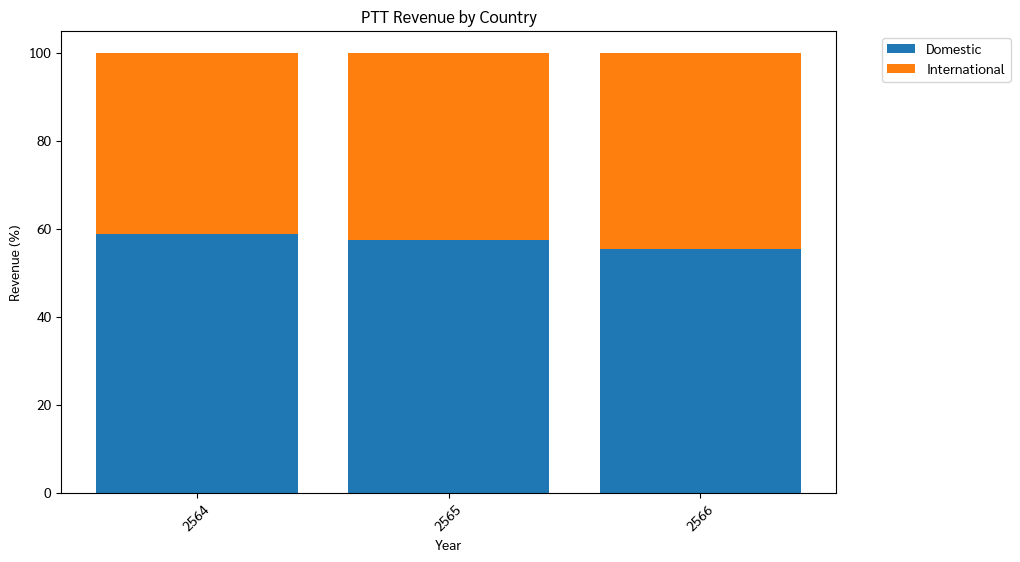

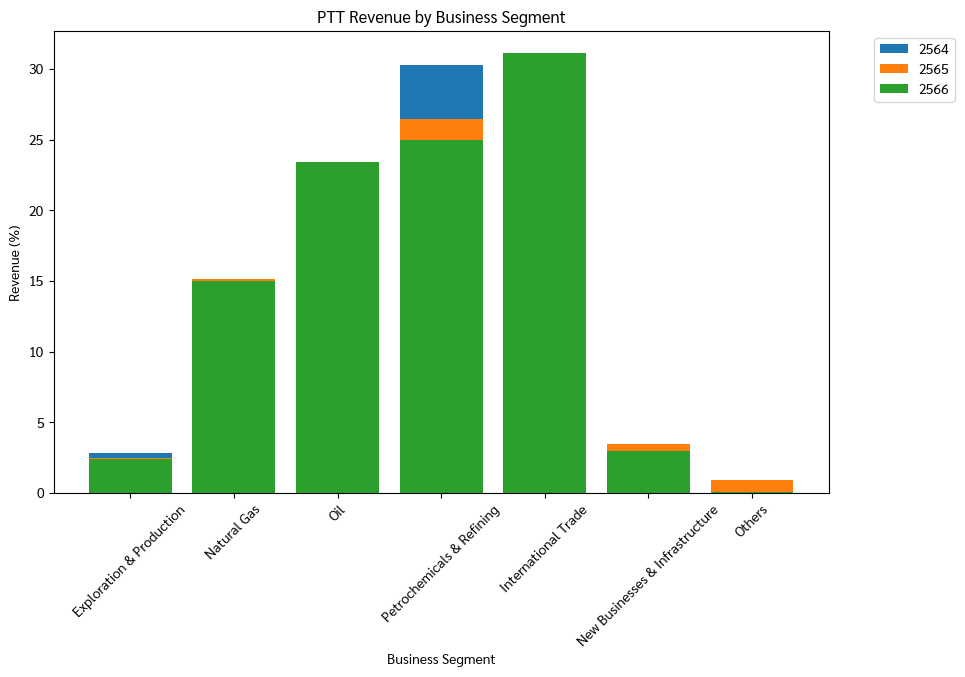


## PTT Financial Analysis

**Revenue Structure:**

* PTT's revenue is derived from both domestic and international operations, with a slight shift towards international markets over the past three years.
* The company's core business segments include natural gas, oil, petrochemicals & refining, and international trade. These segments have contributed consistently to the majority of revenue.
* New businesses and infrastructure, while still a small portion of revenue, show a promising growth trend. 

**Key Observations:**

* PTT's reliance on oil and natural gas suggests vulnerability to fluctuating commodity prices.
* The company's expansion into new businesses and infrastructure demonstrates its commitment to diversification and future growth.
* The increasing international revenue suggests PTT is successfully expanding its geographic reach. 

**Investment Considerations:**

* Investors should consider the potential risks and opportunities associated with the energy sector, including 

In [19]:
prompt = template.safe_substitute(
    SYMBOL=SYMBOL,
    bussiness_type=bussiness_type,
    income_domestic_foriegn=income_domestic_foriegn,
    revenue_by_business_group=revenue_by_business_group,
    other_income_stated_in_financial_statements=other_income_stated_in_financial_statements,
    task="""Act as finanical analyst and analyse this data and write a Python code with the following sections:

1. Comment file header and show your thought how this data can support the investors
2. Use Matplotlib to create some visualisations to ease investors. Note:
 - You need to rotate X-axis ticks with 45 degree.
 - plot legends should be outside the chartz
3. Use a string variable named "conclusion" to store your data analytics and conclusion in Markdown format.

You must give only the answer do not add prologue, prefix and suffix."""
)


python_code = get_gemini_completion(prompt)
exec(python_code.strip("`").lstrip("python").strip())

In [20]:
Markdown(conclusion)


## PTT Financial Analysis

**Revenue Structure:**

* PTT's revenue is derived from both domestic and international operations, with a slight shift towards international markets over the past three years.
* The company's core business segments include natural gas, oil, petrochemicals & refining, and international trade. These segments have contributed consistently to the majority of revenue.
* New businesses and infrastructure, while still a small portion of revenue, show a promising growth trend. 

**Key Observations:**

* PTT's reliance on oil and natural gas suggests vulnerability to fluctuating commodity prices.
* The company's expansion into new businesses and infrastructure demonstrates its commitment to diversification and future growth.
* The increasing international revenue suggests PTT is successfully expanding its geographic reach. 

**Investment Considerations:**

* Investors should consider the potential risks and opportunities associated with the energy sector, including commodity price volatility and environmental regulations.
* The company's diversification strategy, especially in new businesses and infrastructure, presents potential for long-term growth.
* PTT's geographical expansion, particularly in emerging markets, could provide opportunities for investors seeking exposure to international markets.

**Overall, PTT's financial data suggests a company with a strong foundation in traditional energy markets, coupled with a strategic focus on diversification and growth. Investors should carefully evaluate these factors, along with broader market trends, to make informed investment decisions.**


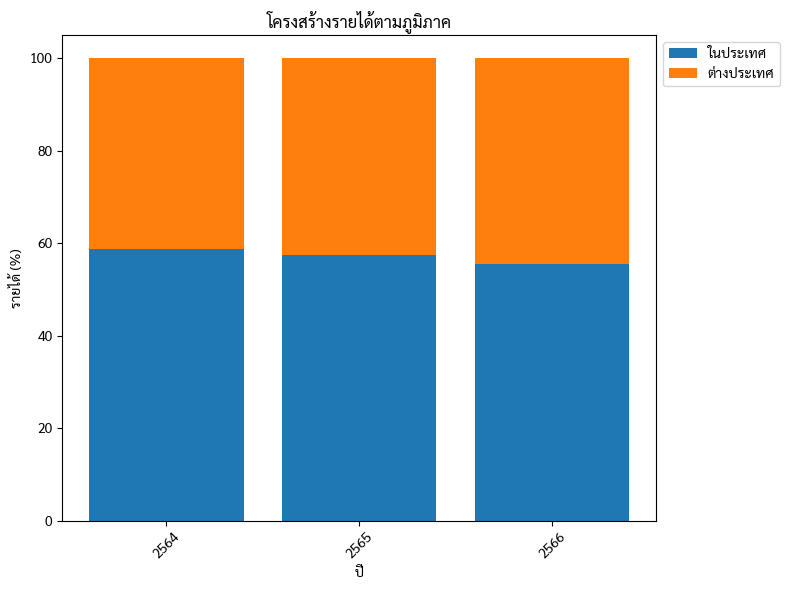

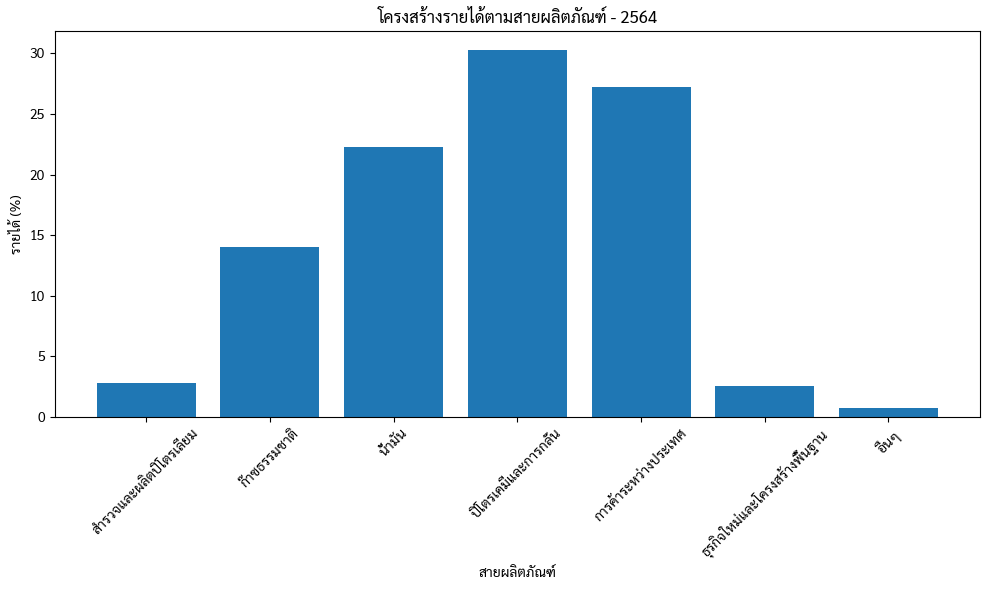

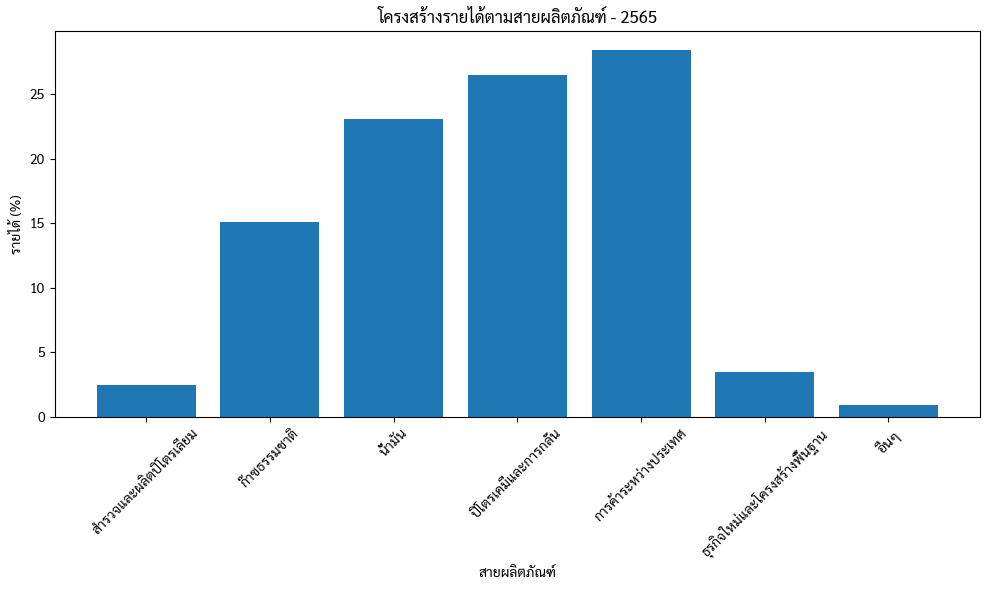

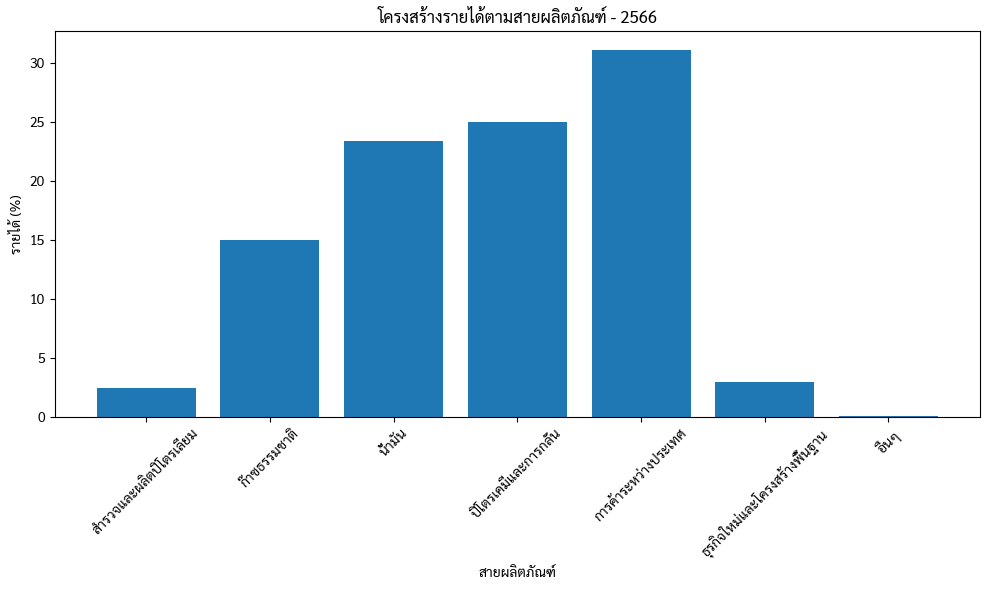


## การวิเคราะห์ข้อมูลทางการเงินของ PTT

จากข้อมูลที่แสดงให้เห็นถึงรายได้ของ PTT ในช่วง 3 ปีที่ผ่านมา (2564 - 2566) เราสามารถสังเกตเห็นแนวโน้มที่น่าสนใจดังนี้:

- **รายได้จากต่างประเทศมีแนวโน้มเพิ่มขึ้นอย่างต่อเนื่อง**:  แสดงให้เห็นถึงความสามารถของ PTT ในการขยายธุรกิจสู่ตลาดต่างประเทศ 
- **สายผลิตภัณฑ์หลักของ PTT คือ น้ำมัน ปิโตรเคมีและการกลั่น และการค้าระหว่างประเทศ**:  การวิเคราะห์รายได้ตามสายผลิตภัณฑ์แสดงให้เห็นว่า 
  ทั้ง 3 สายผลิตภัณฑ์นี้เป็นส่วนสำคัญของรายได้โดยรวมของ PTT
- **ธุรกิจใหม่และโครงสร้างพื้นฐานกำลังเติบโต**: แม้ว่าธุรกิจนี้จะเป็นส่วนเล็กของรายได้ แต่การเติบโตของธุรกิจนี้แสดงให้เห็นถึง 
  ความพยายามของ PTT ในการปรับตัวเข้ากับการเปลี่ยนแปลงของตลาดพลังงาน
  
**สรุป**:  ข้อมูลทางการเงินของ PTT แสดงให้เห็นถึงธุรกิจที่มีความหลากหลายและมีศักยภาพในการเติบโต 
โดยเฉพาะอย่างยิ่งในตลาดต่างประเทศ  นักลงทุนควรติดตามการเติบโตของธุรกิจใหม่และโครงสร้างพื้นฐาน 
รวมถึงการเปลี่ยนแปลงของราคาน้ำมันและก๊าซธรรมชาติ ซึ่งอาจส่งผลกระทบต่อผลประกอบการของ PTT 


In [21]:
prompt = template.safe_substitute(
    SYMBOL=SYMBOL,
    bussiness_type=bussiness_type,
    income_domestic_foriegn=income_domestic_foriegn,
    revenue_by_business_group=revenue_by_business_group,
    other_income_stated_in_financial_statements=other_income_stated_in_financial_statements,
    task="""Act as finanical analyst and analyse this data and write a Python code with the following sections:

1. Comment file header and show your thought how this data can support the investors
2. Use Matplotlib to create some visualisations to ease investors. Note:
 - You need to rotate X-axis ticks with 45 degree.
 - plot legends should be outside the chartz
3. Use a string variable named "conclusion" to store your data analytics and conclusion in Markdown format in Thai language.

You must give only the answer do not add prologue, prefix and suffix."""
)


python_code = get_gemini_completion(prompt)
exec(python_code.strip("`").lstrip("python").strip())
Markdown(conclusion)